In [3]:
import pandas as pd
import json
import requests
from pandas.io.json import json_normalize
from uszipcode import SearchEngine
import dateutil.parser
search = SearchEngine(simple_zipcode=True)

In [4]:
r = requests.get("https://data.cityofchicago.org/resource/6zsd-86xi.json?$where=year BETWEEN '2017' AND '2018'&$limit=600000")
data = r.json()
full_df = pd.DataFrame.from_dict(json_normalize(data), orient='columns')

In [5]:
## util functions
def date_convert(string): 
    d = dateutil.parser.parse(string)

    return d.strftime('%m/%d/%Y')

In [6]:
## set datatypes so that you can get zipcodes from lat long
full_df[['latitude','longitude']] = full_df[['latitude','longitude']].apply(pd.to_numeric)
df_get_zipcodes = full_df.dropna(subset=['location.coordinates'])
df_get_zipcodes = df_get_zipcodes.drop_duplicates(subset=['block'])
df_get_zipcodes['zipcode'] = df_get_zipcodes.apply(lambda x: search.by_coordinates(x['latitude'], x['longitude'])[0].zipcode, axis=1)
df_with_zipcodes = df_get_zipcodes.loc[:,['block','zipcode']]
# merge with short df to get zipcodes for every row, then do analysis


In [8]:
df_with_zip = pd.merge(full_df, df_with_zipcodes, on='block', how='left')
df_with_zip['date'] = df_with_zip['date'].apply(lambda x: date_convert(x))
df_with_zip['date'] = pd.to_datetime(df_with_zip['date'])

In [9]:
## create counts dataframe
df_with_counts = df_with_zip.groupby(['zipcode','primary_type']).size().unstack().fillna(0)

In [126]:
## Get census data 
response = requests.get('https://api.census.gov/data/2017/acs/acs5?get=B15003_017E,B01003_001E,B17001_002E,B10050_003E,B02009_001E&for=zip code tabulation area:*')
data = response.json()
census_df = pd.DataFrame(data[1:], columns=data[0])

In [125]:
## clean and structure census data
codes = {
    'B15003_017E': 'educ',
    'B01003_001E': 'pop',
    'B17001_002E': 'total_below_poverty',
    'B10050_003E': 'total_with_grandparents',
    'B02009_001E': 'total_black_pop',
    'zip code tabulation area': 'zipcode'
}

census_df.columns = [codes[col] for col in census_df.columns]
## merge with counts
merged_df = pd.merge(df_with_counts, census_df, on='zipcode', how='inner')

for col in merged_df.columns: 
	merged_df[col] = pd.to_numeric(merged_df[col])

KeyError: 'educ'

In [12]:
## Calculate rates
chars = ['educ','total_below_poverty','total_with_grandparents', 'total_black_pop']
for col in chars:
    name = col + '_rate'
    merged_df[name] = (merged_df[col]/merged_df['pop'])

In [14]:
# Problem 3 
df_per_month = df_with_zip.set_index('date').groupby(pd.Grouper(freq='M')).size()
incidents_df = pd.DataFrame({'date':df_per_month.index, 'count':df_per_month.values})
## Total Counts of Incidents per Month 

## Total Counts of Arrests per Month

In [18]:
incidents_df['month'] = incidents_df['date'].apply(lambda x: x.month)
incidents_df['year'] = incidents_df['date'].apply(lambda x: x.year)

Text(0.5, 1.0, 'Total Incidents per Month')

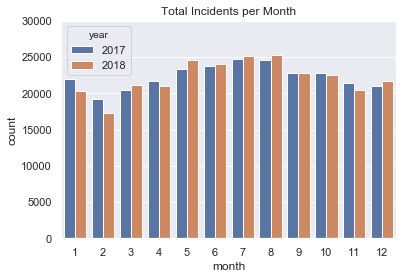

In [19]:
import seaborn as sns
sns.set(style="darkgrid")
ax = sns.barplot(x='month', y='count', data=incidents_df, hue='year')
ax.set_ylim(bottom=0, top=30000)
ax.set_title("Total Incidents per Month")

In [127]:
total_year = incidents_df.groupby('year').sum()['count']
pct_change = ((total_year[2018] - total_year[2017])/ total_year[2017])*100
pct_change

## With a change in total crime of -0.66%, overall, crime has decreased by .66% from 2017 to 2018. 

-0.6583217085779505

In [84]:
## Determine number of months where crime was lower in 2018 than 2018. 
tot = 0
for name, group in incidents_df.groupby(['month']):
    if (group.iloc[0]['count'] > group.iloc[1]['count']):
        tot += 1
## 5 months in 2018 had total lower crime counts than 2017. 



In [112]:
# Problem 3 Part Deux 
import datetime
full_df_3 = df_with_zip[(df_with_zip['ward'] == '43') & ((df_with_zip['date'].dt.month ==7) & (df_with_zip['date'].dt.day <27))]


In [113]:
df_3 = full_df_3.groupby(['year', 'primary_type']).size().unstack()
df_3

primary_type,ASSAULT,BATTERY,BURGLARY,CRIM SEXUAL ASSAULT,CRIMINAL DAMAGE,CRIMINAL TRESPASS,DECEPTIVE PRACTICE,INTERFERENCE WITH PUBLIC OFFICER,KIDNAPPING,LIQUOR LAW VIOLATION,MOTOR VEHICLE THEFT,NARCOTICS,NON-CRIMINAL,OFFENSE INVOLVING CHILDREN,OTHER OFFENSE,PUBLIC PEACE VIOLATION,ROBBERY,SEX OFFENSE,THEFT,WEAPONS VIOLATION
year,,,,,,,,,,,,,,,,,,,,
2017,5.0,38.0,14.0,2.0,24.0,7.0,30.0,1.0,2.0,NaN,6.0,1.0,1.0,2.0,4.0,1.0,15.0,5.0,153.0,NaN
2018,15.0,30.0,14.0,NaN,25.0,16.0,31.0,NaN,NaN,2.0,10.0,1.0,NaN,1.0,13.0,1.0,8.0,5.0,173.0,2.0


In [108]:
print(((df_3.loc['2018','ROBBERY']-df_3.loc['2017','ROBBERY'])/df_3.loc['2017','ROBBERY'])*100)
print(((df_3.loc['2018','BURGLARY']-df_3.loc['2017','BURGLARY'])/df_3.loc['2017','BURGLARY'])*100)
print(((df_3.loc['2018','MOTOR VEHICLE THEFT']-df_3.loc['2017','MOTOR VEHICLE THEFT'])/df_3.loc['2017','MOTOR VEHICLE THEFT'])*100)


-46.666666666666664
0.0
66.66666666666666


In [123]:
full_df_3.groupby(['year', 'primary_type']).size().unstack()

primary_type,ASSAULT,BATTERY,BURGLARY,CRIM SEXUAL ASSAULT,CRIMINAL DAMAGE,CRIMINAL TRESPASS,DECEPTIVE PRACTICE,INTERFERENCE WITH PUBLIC OFFICER,KIDNAPPING,LIQUOR LAW VIOLATION,MOTOR VEHICLE THEFT,NARCOTICS,NON-CRIMINAL,OFFENSE INVOLVING CHILDREN,OTHER OFFENSE,PUBLIC PEACE VIOLATION,ROBBERY,SEX OFFENSE,THEFT,WEAPONS VIOLATION
year,,,,,,,,,,,,,,,,,,,,
2017,5.0,38.0,14.0,2.0,24.0,7.0,30.0,1.0,2.0,NaN,6.0,1.0,1.0,2.0,4.0,1.0,15.0,5.0,153.0,NaN
2018,15.0,30.0,14.0,NaN,25.0,16.0,31.0,NaN,NaN,2.0,10.0,1.0,NaN,1.0,13.0,1.0,8.0,5.0,173.0,2.0


In [167]:
## Problem 4.A 

#df_with_zip[df_with_zip['block'].str.contains('S Michigan Ave')]

max_prob = df_with_zip[df_with_zip['zipcode'] == '60616'].groupby(
    'primary_type').size().apply(
    lambda x: x / df_with_zip[df_with_zip['zipcode'] == '60616'].
    groupby('primary_type').size().sum()).to_frame('likelihood')

max_prob.loc[max_prob['likelihood'].idxmax()]

In [193]:
## Problem 4.B 
# THEFT_GARFIELD = df_with_zip[df_with_zip['community_area'].isin(['26','27'])].groupby(
#     'primary_type').size().apply(
#     lambda x: x / df_with_zip[df_with_zip['community_area'].isin(['26','27'])].
#     groupby('primary_type').size().sum()).to_frame('likelihood').loc['THEFT']

# THEFT_UPTOWN = df_with_zip[df_with_zip['community_area'].isin(['3'])].groupby(
#     'primary_type').size().apply(
#     lambda x: x / df_with_zip[df_with_zip['community_area'].isin(['3'])].
#     groupby('primary_type').size().sum()).to_frame('likelihood').loc['THEFT']

# (THEFT_GARFIELD) - (THEFT_UPTOWN) 'to have come from Garfield'

likelihood   -0.151074
Name: THEFT, dtype: float64

In [208]:
theft_df = df_with_zip[df_with_zip['primary_type'] == 'THEFT']

In [215]:
theft = len(theft_df.index)
garfield_and_theft = df_with_zip[(df_with_zip['primary_type'] == 'THEFT') & (df_with_zip['community_area'].isin(['26','27']))].groupby('community_area').size().sum()
uptown_and_theft = df_with_zip[(df_with_zip['primary_type'] == 'THEFT') & (df_with_zip['community_area'].isin(['3']))].groupby('community_area').size().sum()

In [219]:
prob_uptown = uptown_and_theft/theft
prob_garfied = garfield_and_theft/theft

In [220]:
prob_uptown

0.015097196897116543

In [221]:
prob_garfied

0.01926940074790617

In [128]:
## .4 percentage points more likely to come from Garfield 
df_with_zip[(df_with_zip['primary_type'] == 'THEFT') & (df_with_zip['community_area'].isin(['26','27']))].groupby('community_area').size().sum()

2494

In [ ]:
## 4.C 
## If a call comes about Battery, there's a 38% chance it's from Garfield and a 62% chance its from Uptown, 
## so it's 24 percentage points more likely to be from Uptown. 
## P(Garfield | Battery) = 100/260 = .38
## P(Uptown | Battery) = 160/260 = .615

In [124]:
df_with_zip.columns

Index(['arrest', 'beat', 'block', 'case_number', 'community_area', 'date',
       'description', 'district', 'domestic', 'fbi_code', 'id', 'iucr',
       'latitude', 'location.coordinates', 'location.type',
       'location_description', 'longitude', 'primary_type', 'updated_on',
       'ward', 'x_coordinate', 'y_coordinate', 'year', 'zipcode'],
      dtype='object')

In [251]:
df_with_zip[df_with_zip['arrest'] == True]

,arrest,beat,block,case_number,community_area,date,description,district,domestic,fbi_code,...,location.type,location_description,longitude,primary_type,updated_on,ward,x_coordinate,y_coordinate,year,zipcode
0,True,1034,026XX S CALIFORNIA BLVD,JA529032,30,2017-11-28,VIOLENT OFFENDER: ANNUAL REGISTRATION,010,False,26,...,Point,JAIL / LOCK-UP FACILITY,-87.694638,OTHER OFFENSE,2018-02-11T15:54:58.000,12,1158280,1886310,2017,60608
1,True,1221,007XX N SACRAMENTO BLVD,JA545986,23,2017-12-11,ARMED: HANDGUN,012,False,03,...,Point,SIDEWALK,-87.702169,ROBBERY,2018-02-11T15:54:58.000,27,1156092,1904769,2017,60622
5,True,0215,003XX E 47TH ST,JA522842,38,2017-11-23,AGGRAVATED: HANDGUN,002,False,04A,...,Point,DEPARTMENT STORE,-87.619099,ASSAULT,2018-06-21T15:59:22.000,3,1178967,1873924,2017,60653
10,True,1014,016XX S HARDING AVE,JB108320,29,2018-01-08,MANU/DELIVER: HEROIN (WHITE),010,False,18,...,Point,RESIDENCE,-87.723691,NARCOTICS,2018-05-04T15:51:04.000,24,1150326,1891538,2018,60623
16,True,1612,062XX N OLCOTT AVE,JB108167,10,2018-01-08,DOMESTIC BATTERY SIMPLE,016,False,08B,...,Point,RESIDENCE,-87.813665,BATTERY,2018-05-04T15:51:04.000,41,1125516,1940832,2018,60631
23,True,0611,079XX S HERMITAGE AVE,JB108348,71,2018-01-08,AGGRAVATED:KNIFE/CUTTING INSTR,006,False,04A,...,Point,APARTMENT,-87.667067,ASSAULT,2018-05-04T15:51:04.000,21,1166058,1852115,2018,60620
49,True,2411,072XX N CALIFORNIA AVE,JA440032,2,2017-09-21,COUNTERFEIT CHECK,024,False,10,...,Point,CURRENCY EXCHANGE,-87.699714,DECEPTIVE PRACTICE,2018-03-01T15:52:35.000,50,1156443,1947707,2017,60645
50,True,2515,055XX W GRAND AVE,JA470589,19,2017-10-12,TO CITY OF CHICAGO PROPERTY,025,False,14,...,Point,JAIL / LOCK-UP FACILITY,-87.765511,CRIMINAL DAMAGE,2018-03-01T15:52:35.000,29,1138788,1913480,2017,60639
51,True,0922,043XX S TALMAN AVE,JA491697,58,2017-10-30,SEX OFFENDER: FAIL REG NEW ADD,009,False,26,...,Point,APARTMENT,-87.690727,OTHER OFFENSE,2018-03-01T15:52:35.000,12,1159425,1875711,2017,60632
52,True,2514,055XX W BELMONT AVE,JA521389,19,2017-09-29,BOGUS CHECK,025,False,11,...,Point,CURRENCY EXCHANGE,-87.765831,DECEPTIVE PRACTICE,2018-03-01T15:52:35.000,30,1138653,1920720,2017,60641


,date,count
0,2017-01-31,22012
1,2017-02-28,19257
2,2017-03-31,20509
3,2017-04-30,21636
4,2017-05-31,23332
5,2017-06-30,23794
6,2017-07-31,24798
7,2017-08-31,24658
8,2017-09-30,22772
9,2017-10-31,22849
